In [43]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [44]:
# Neural network for Forecasting data
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.01,    #0.05               best with 0.001
  decay_steps=100, #100        best with 100
  decay_rate=1, #1              best with 1
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

def get_callbacks(name):
    return [
        tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=300, min_delta=0.0001),
        ]

def compile_and_fit(model, name, x_train, y_train, x_test, y_test, optimizer=None, max_epochs=1000):

    if optimizer is None:
        optimizer = get_optimizer()

    model.compile(optimizer=optimizer,
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=[
                  tf.keras.losses.MeanAbsoluteError("auto", "mean_absolute_error"),
                  'accuracy'])

    model.summary()

    history = model.fit(
            x_train, y_train,
            epochs=max_epochs,
            validation_data=(x_test, y_test),
            callbacks=get_callbacks(name),
            verbose=2)

    return history

In [45]:
#Training data set
folder = 'Burgers'

input_train=np.load('../data/' + folder + '/input_train.npy')
input_test=np.load('../data/' + folder + '/input_test.npy')
output_train=np.load('../data/' + folder + '/output_train.npy')
output_test=np.load('../data/' + folder + '/output_test.npy')

INPUTDIM = (input_train.shape[1],)
OUTPUTDIM = (output_train.shape[1],)

In [46]:
import tensorflow as tf

class FFT_Layer(tf.keras.layers.Layer):
    def __init__(self, k_max=None, **kwargs):
        super(FFT_Layer, self).__init__(**kwargs)
        self._fft_shape = None
        self._ifft_shape = None
        self.k_max = k_max

    def build(self, input_shape):
        if self.k_max == None:
            self._fft_shape = tf.convert_to_tensor(input_shape[-1] // 2 + 1, dtype=tf.int32)
            self._ifft_shape = tf.multiply(tf.convert_to_tensor(input_shape[-1] // 2, dtype=tf.int32), 2)
        else:
            self._fft_shape = tf.convert_to_tensor(self.k_max, dtype=tf.int32)
            self._ifft_shape = tf.multiply(tf.convert_to_tensor(self.k_max-1, dtype=tf.int32), 2)
        print('fft_shape set:', self._fft_shape.numpy())
        print('ifft_shape set:', self._ifft_shape.numpy())

        self.kernel = self.add_weight(
            name="kernel",
            shape=(self.fft_shape, self._fft_shape),
            initializer="glorot_uniform",
            trainable=True
        )

    def call(self, inputs):
        fft = tf.signal.rfft(inputs)
        if not(self.k_max==None):
            fft = fft[..., :self.k_max]
        kernel_complex = tf.complex(self.kernel, tf.zeros_like(self.kernel))
        r = tf.linalg.matmul(fft, kernel_complex)
        ifft = tf.signal.irfft(r)
        return ifft

    @property
    def fft_shape(self):
        return self._fft_shape

    @property
    def ifft_shape(self):
        return self._ifft_shape

class Bias_Layer(tf.keras.layers.Layer):
    def __init__(self, fft_layer_object, **kwargs):
        super(Bias_Layer, self).__init__(**kwargs)
        self.fft_layer_object = fft_layer_object

    def build(self, input_shape):
        self.kernel = self.add_weight(
            name="kernel",
            shape=(input_shape[-1], self.fft_layer_object.ifft_shape),
            initializer="glorot_uniform",
            trainable=True
        )
        print('Bias layer has shape: '+str(self.fft_layer_object.ifft_shape.numpy()))

    def call(self, inputs):
        bias = tf.linalg.matmul(inputs, self.kernel)
        return bias

class Fourier_Layer(tf.keras.layers.Layer):
    
    def __init__(self, k_max=None, **kwargs):
        super(Fourier_Layer, self).__init__(**kwargs)
        self.fft_layer = FFT_Layer(k_max=k_max)
        self.bias_layer = Bias_Layer(self.fft_layer)

    def call(self, inputs):
        fft_layer = self.fft_layer(inputs)
        bias_layer = self.bias_layer(inputs)
        added_layers = layers.Add() ([fft_layer, bias_layer])
        return layers.Activation('relu') (added_layers)
    

n=6
k_max = 9
p_dim = 256

input_layer = layers.Input(shape = INPUTDIM, name= 'input_layer')

P_layer = layers.Dense(p_dim, activation='relu', kernel_regularizer = regularizers.l2(0.2), name='P_layer') (input_layer)

# Repeat the custom module 'n' times
for i in range(n):
    print('Creating Fourier Layer ' +str(i))
    if i ==0:
        fourier_module_output = Fourier_Layer(name='fourier_layer_'+str(i), k_max=k_max)(P_layer)
    else:
        fourier_module_output = Fourier_Layer(name='fourier_layer_'+str(i), k_max=k_max)(fourier_module_output)

output_layer = layers.Dense(OUTPUTDIM[0], activation='linear', kernel_regularizer = regularizers.l2(0.2), name='output_layer') (fourier_module_output)

print('-------------------------------------------------------')

model = tf.keras.Model(inputs=input_layer, outputs = output_layer, name ='FNO')

model.summary()


Creating Fourier Layer 0
fft_shape set: 9
ifft_shape set: 16
Bias layer has shape: 16
Creating Fourier Layer 1
fft_shape set: 9
ifft_shape set: 16
Bias layer has shape: 16
Creating Fourier Layer 2
fft_shape set: 9
ifft_shape set: 16
Bias layer has shape: 16
Creating Fourier Layer 3
fft_shape set: 9
ifft_shape set: 16
Bias layer has shape: 16
Creating Fourier Layer 4
fft_shape set: 9
ifft_shape set: 16
Bias layer has shape: 16
Creating Fourier Layer 5
fft_shape set: 9
ifft_shape set: 16
Bias layer has shape: 16
-------------------------------------------------------
Model: "FNO"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 65)]              0         
                                                                 
 P_layer (Dense)             (None, 256)               16896     
                                                                 
 fourier_layer_0 (F

In [47]:
history = compile_and_fit(model, model.name, x_train=input_train, y_train=output_train, x_test=input_test, y_test=output_test, optimizer=None, max_epochs=5000)

Model: "FNO"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 65)]              0         
                                                                 
 P_layer (Dense)             (None, 256)               16896     
                                                                 
 fourier_layer_0 (Fourier_La  (None, 16)               4177      
 yer)                                                            
                                                                 
 fourier_layer_1 (Fourier_La  (None, 16)               337       
 yer)                                                            
                                                                 
 fourier_layer_2 (Fourier_La  (None, 16)               337       
 yer)                                                            
                                                               

Total params: 23,863
Trainable params: 23,863
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5000
5/5 - 10s - loss: 18.0828 - mean_absolute_error: 0.2722 - accuracy: 0.0125 - val_loss: 8.7865 - val_mean_absolute_error: 0.1405 - val_accuracy: 0.0156 - 10s/epoch - 2s/step
Epoch 2/5000
5/5 - 0s - loss: 5.7369 - mean_absolute_error: 0.1321 - accuracy: 0.0250 - val_loss: 2.6970 - val_mean_absolute_error: 0.1421 - val_accuracy: 0.0125 - 305ms/epoch - 61ms/step
Epoch 3/5000
5/5 - 0s - loss: 1.9697 - mean_absolute_error: 0.1324 - accuracy: 0.0188 - val_loss: 1.3682 - val_mean_absolute_error: 0.1409 - val_accuracy: 0.0156 - 208ms/epoch - 42ms/step
Epoch 4/5000
5/5 - 0s - loss: 1.2529 - mean_absolute_error: 0.1305 - accuracy: 0.0125 - val_loss: 1.1300 - val_mean_absolute_error: 0.1396 - val_accuracy: 0.0078 - 207ms/epoch - 41ms/step
Epoch 5/5000
5/5 - 0s - loss: 1.0105 - mean_absolute_error: 0.1300 - accuracy: 0.0250 - val_loss: 0.8167 - val_mea

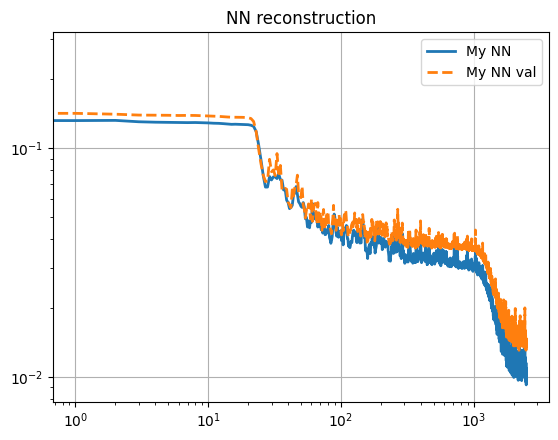

In [48]:
bc     = history.history['mean_absolute_error']
val_bc = history.history['val_mean_absolute_error']

plt.loglog(range(np.shape(bc)[0]),bc, linewidth=2,)
plt.loglog(range(np.shape(val_bc)[0]),val_bc,'--', linewidth=2,)
plt.title('NN reconstruction')
plt.grid(True)

plt.legend(('My NN','My NN val'))
plt.show()

In [49]:
rec_output = model.predict(input_test)

20/20 [==============================] - 0s 3ms/step


Text(0.5, 0, 'x [-]')

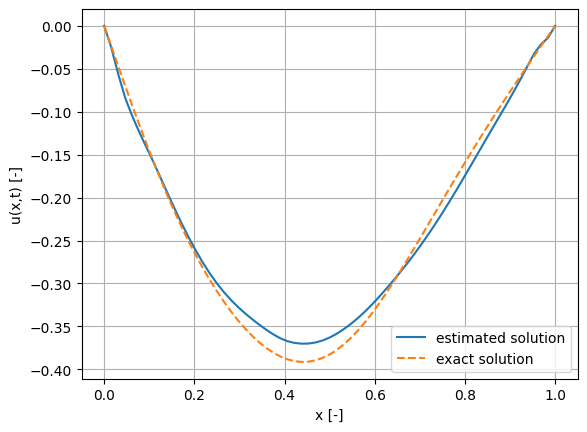

In [61]:
index = 17
xx=np.linspace(0,1,rec_output.shape[1])

plt.figure()
plt.grid(True)
plt.plot(xx,rec_output[index,:], label='estimated solution')
plt.plot(xx,output_test[index,:], label='exact solution', linestyle='--')
#plt.plot(xx,input_train[index,:], label='input', linestyle='--')
plt.legend()
plt.ylabel('u(x,t) [-]')
plt.xlabel('x [-]')


In [55]:
save_NN = False
# save_NN = True
if save_NN:
    model.save('../data/'+folder+'/model_NN.h5')
    print('NN saved in '+str(folder))

NN saved in Burgers
